This Jupyter Notebook is developed for demonstration purposes to showcase the implementation of the FinDiff model.

In [1]:
# main libraries for data processing/plotting
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
import seaborn as sns

# import torch functionality
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# import synthetic data vault library
from sdv.metadata import SingleTableMetadata
import sdv.evaluation.single_table as sdv_st

#  import local developed models
from MLPSynthesizer import MLPSynthesizer
from BaseDiffuser import BaseDiffuser
from findiff_modules import train_epoch, decode_sample, generate_samples

%load_ext autoreload
%autoreload 2


Set params and seed

In [2]:
# define experiment parameters
exp_params = dict(

    seed = 111,
    batch_size = 512,
    epochs = 3000,
    n_cat_emb = 2, # size of the categorical embeddings (2 means each attribute will be 2-dimensional)
    learning_rate = 1e-4,

    mlp_layers = [1024, 1024, 1024, 1024], # total neurons at each hidden feed-forward layer
    activation = 'lrelu',

    diffusion_steps = 500,
    diffusion_beta_start = 1e-4,
    diffusion_beta_end = 0.02,
    scheduler = 'linear'
)
    
# set seed
np.random.seed(exp_params['seed'])  # set numpy seed
torch.manual_seed(exp_params['seed'])  # set pytorch seed CPU
torch.cuda.manual_seed(exp_params['seed'])  # set pytorch seed GPU


# Load and preprecess dataset. 
For showcasing UCI Credit Card dataset was used, available at https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In [3]:
# read csv file
train_raw = pd.read_csv(r'data/UCI_Credit_Card.csv')

# remove underscore in column names for correct inverse decoding
train_raw.columns = [col.replace('_', '') for col in train_raw.columns]

# identify numeric and categorical attributes
cat_attrs = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY0', 'PAY2', 'PAY3', 'PAY4', 'PAY5', 'PAY6']
num_attrs = ['LIMITBAL', 'BILLAMT1', 'BILLAMT2', 'BILLAMT3', 'BILLAMT4', 'BILLAMT5', 'BILLAMT6',
             'PAYAMT1', 'PAYAMT2', 'PAYAMT3', 'PAYAMT4', 'PAYAMT5', 'PAYAMT6']

# add col name to every entry to make them distinguishable for embedding
for cat_attr in cat_attrs:
    train_raw[cat_attr] = cat_attr + '_' + train_raw[cat_attr].astype('str')

# extract label
label_name = 'default.payment.next.month'
label = train_raw[label_name]


In [4]:
# take cat and num subsets
train = train_raw[[*cat_attrs, *num_attrs]]

# update categorical attributes
train[cat_attrs] = train[cat_attrs].astype(str)

print('Processed data: Train shape: {}'.format(train.shape))

Processed data: Train shape: (30000, 23)


In [5]:
### transform numeric attributes
num_scaler = QuantileTransformer(output_distribution='normal', random_state=exp_params['seed'])
num_scaler.fit(train[num_attrs])
train_num_scaled = num_scaler.transform(train[num_attrs])

### transform categorical attributes
# get unique values
vocabulary_classes = np.unique(train[cat_attrs])
# fit label encoder
label_encoder = LabelEncoder().fit(vocabulary_classes)
# transform dataset
train_cat_scaled = train[cat_attrs].apply(label_encoder.transform)
# collect unique categories of each attribute
vocab_per_attr = {cat_attr: set(train_cat_scaled[cat_attr]) for cat_attr in cat_attrs}

# init torch tensors
train_num_torch = torch.FloatTensor(train_num_scaled)
train_cat_torch = torch.LongTensor(train_cat_scaled.values)
label_torch = torch.LongTensor(label)

print('Encoded categorical data: Train shape: {}'.format(train_cat_torch.shape))
print('Encoded numerical data: Train shape: {}'.format(train_num_torch.shape))

Encoded categorical data: Train shape: torch.Size([30000, 10])
Encoded numerical data: Train shape: torch.Size([30000, 13])


In [6]:
# prepare DataLoader
train_set = TensorDataset(
    train_cat_torch,
    train_num_torch,
    label_torch
)

dataloader = DataLoader(
    dataset=train_set,
    batch_size=exp_params['batch_size'],
    num_workers=0, 
    shuffle=True
)


# Initialize and train the model

In [7]:
n_cat_tokens = len(vocabulary_classes)
cat_dim = exp_params['n_cat_emb'] * len(cat_attrs)
encoded_dim = cat_dim + len(num_attrs)

# initialize the synthesizer
synthesizer = MLPSynthesizer(
    d_in=encoded_dim,
    hidden_layers=exp_params['mlp_layers'],
    activation=exp_params['activation'],
    n_cat_tokens=n_cat_tokens,
    n_cat_emb=exp_params['n_cat_emb'],
    n_classes=pd.Series(label).nunique(),
    embedding_learned=False
)

# initialize the diffuser
diffuser = BaseDiffuser(
    total_steps=exp_params['diffusion_steps'],
    beta_start=exp_params['diffusion_beta_start'],
    beta_end=exp_params['diffusion_beta_end'],
    scheduler=exp_params['scheduler']
)


In [8]:
# init optimizer, scheduler and loss function
parameters = filter(lambda p: p.requires_grad, synthesizer.parameters())
optimizer = optim.Adam(parameters, lr=exp_params['learning_rate'])
scheduler = CosineAnnealingLR(optimizer, T_max=exp_params['epochs'], verbose=False)
loss_fnc = nn.MSELoss()

In [9]:
# list for collection of training losses
losses_all = []

# iterate over distinct training epochs
desc_info = f"INFO: FinDiff training"
pbar = tqdm(iterable=range(exp_params['epochs']), position=0, leave=True)
for epoch in pbar:

    base_params = {'epoch': epoch, 'seed': exp_params['seed'], 'mlp_layers': exp_params['mlp_layers']}

    # train single epoch
    train_losses = train_epoch(
        dataloader=dataloader,
        synthesizer=synthesizer,
        diffuser=diffuser,
        loss_fnc=loss_fnc,
        optimizer=optimizer,
        scheduler=scheduler
    )
    losses_all.append({**base_params, **train_losses})

    # add description to the progress bar
    desc_losses = ' | '.join([f'{name}: {loss:.3f}' for name, loss in train_losses.items()])
    pbar.set_description(desc_info + ' | ' + desc_losses)


INFO: FinDiff training | losses: 0.109: 100%|██████████| 3000/3000 [1:28:15<00:00,  1.77s/it]


# Sampling

In [ ]:
# generate new samples
generated_samples = generate_samples(
    synthesizer=synthesizer,
    diffuser=diffuser,
    encoded_dim=encoded_dim,
    last_diff_step=exp_params['diffusion_steps'],
    label=label_torch
)
# decode generated samples, i.e. numeric upscaling + categorical inverse encoding
generated_samples_df = decode_sample(
    sample=generated_samples,
    cat_dim=cat_dim,
    n_cat_emb=exp_params['n_cat_emb'],
    num_attrs=num_attrs,
    cat_attrs=cat_attrs,
    num_scaler=num_scaler,
    vocab_per_attr=vocab_per_attr,
    label_encoder=label_encoder,
    synthesizer=synthesizer
)

# Evaluate generated data

In [11]:
# build a metadata for evaluation (from SDV)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=train)

# generate quality report
quality_report = sdv_st.evaluate_quality(
    real_data=train,
    synthetic_data=generated_samples_df,
    metadata=metadata
)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 253/253 [00:03<00:00, 65.11it/s] 

Overall Quality Score: 89.0%

Properties:
- Column Shapes: 96.34%
- Column Pair Trends: 81.66%


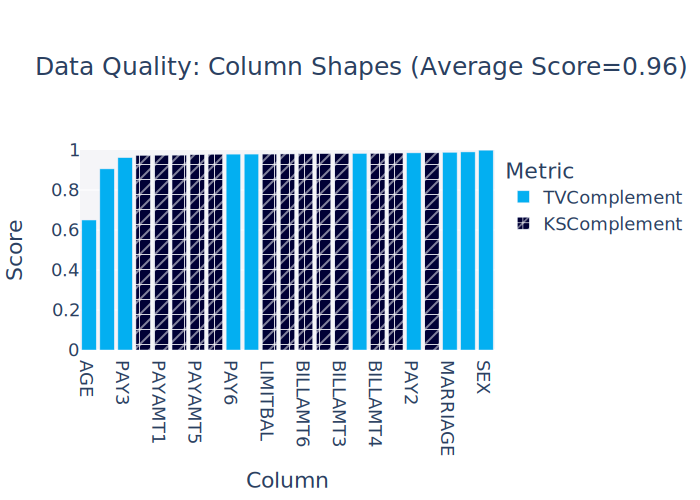

In [21]:
# plot Column Shapes -> referred to the "Fidelity Column" in the paper
fig1 = quality_report.get_visualization(property_name='Column Shapes')
fig1.show(renderer="svg")

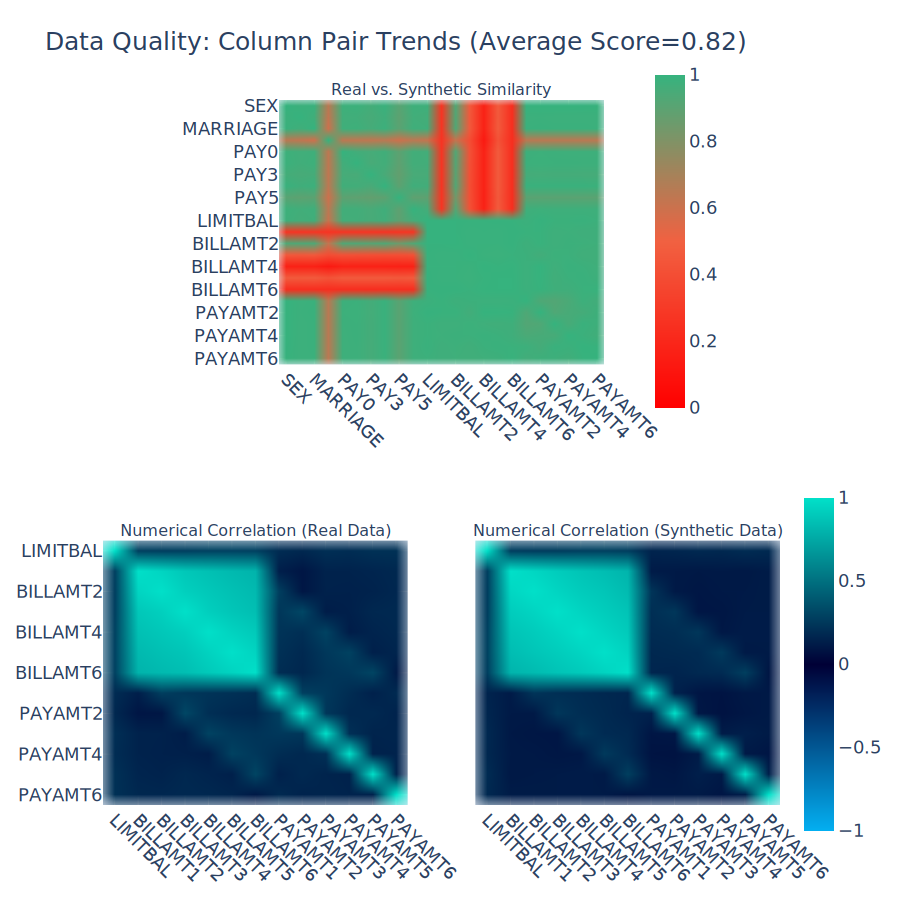

In [22]:
# plot Column Pair Trends -> referred to the "Fidelity Row" in the paper
fig2 = quality_report.get_visualization(property_name='Column Pair Trends')
fig2.show(renderer="svg")   
